In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

In [2]:
df = pd.read_csv('training_set_fd.csv', sep=';')
print(len(df))

# 17998 Istanze nel dataset

17998


In [3]:
print(df.isnull().sum())

# Mancano 5 elementi in marital_status e 17 in claim_est_payout

claim_number           0
age_of_driver          0
gender                 0
marital_status         5
annual_income          0
high_education_ind     0
address_change_ind     0
living_status          0
claim_day_of_week      0
accident_site          0
past_num_of_claims     0
channel                0
claim_est_payout      17
age_of_vehicle         8
vehicle_category       0
vehicle_price          0
vehicle_color          0
vehicle_weight         0
fraud                  0
dtype: int64


In [4]:
print(df['fraud'].value_counts())

# Il dataset NON è bilanciato sul target "fraud" (molti piu casi di non frode)

0    15182
1     2816
Name: fraud, dtype: int64


<Axes: >

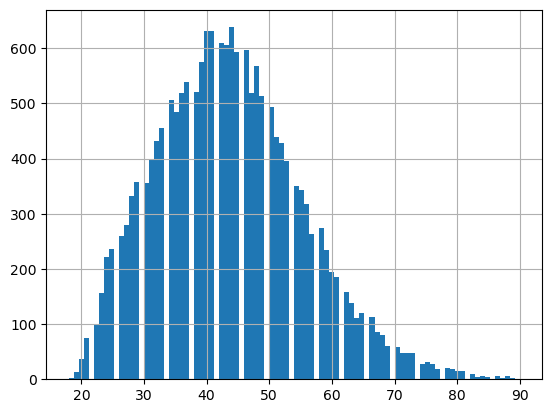

In [5]:
valid_drivers = df[df['age_of_driver'] < 91]

valid_drivers["age_of_driver"].hist(bins=90)

<Axes: xlabel='age_of_driver'>

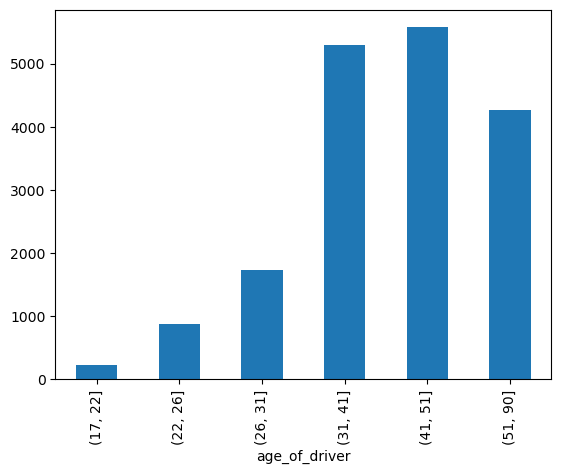

In [6]:
bins = [17, 22, 26, 31, 41, 51, 90]
grouped_valid_drivers = valid_drivers.groupby(pd.cut(valid_drivers['age_of_driver'], bins=bins))
grouped_valid_drivers.size().plot(kind='bar')

<Axes: xlabel='age_of_driver'>

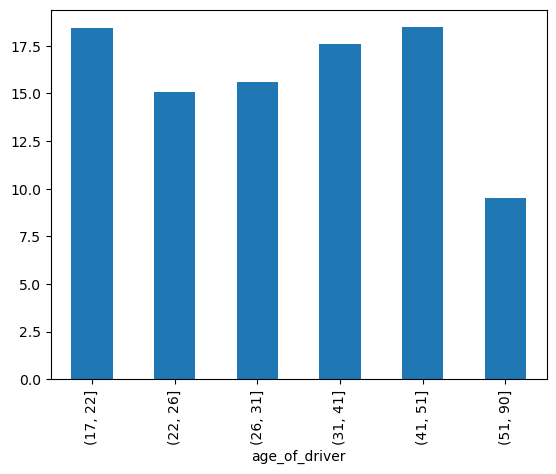

In [7]:
fraud_percentage = grouped_valid_drivers['fraud'].sum() / grouped_valid_drivers['fraud'].count() * 100
fraud_percentage.plot(kind='bar')

<Axes: xlabel='gender,age_of_driver'>

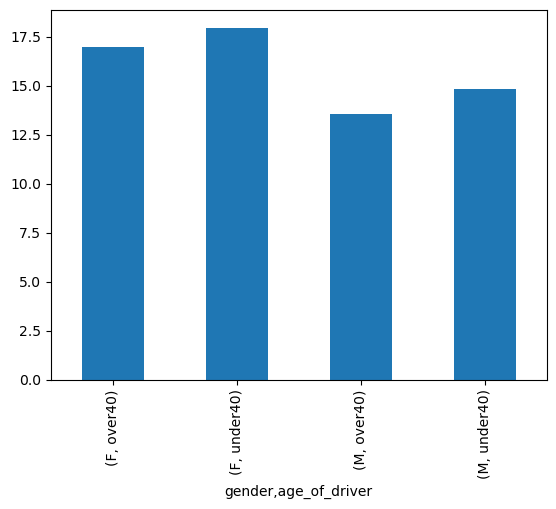

In [8]:
df2 = df.copy()
df2["age_of_driver"] = np.where(df2["age_of_driver"] < 40, "under40", "over40")
tmp = df2.copy()
df2 = df2[df2["fraud"] == 1]
grouped = df2.groupby(["gender", "age_of_driver"])

p = grouped["fraud"].count() / tmp.groupby(["gender", "age_of_driver"])["fraud"].count() * 100
p.plot(kind='bar')

# La categoria F under40 è quella con la percentuale di frodi più alta, in generale le frodi sono più frequenti tra le donne

<Axes: >

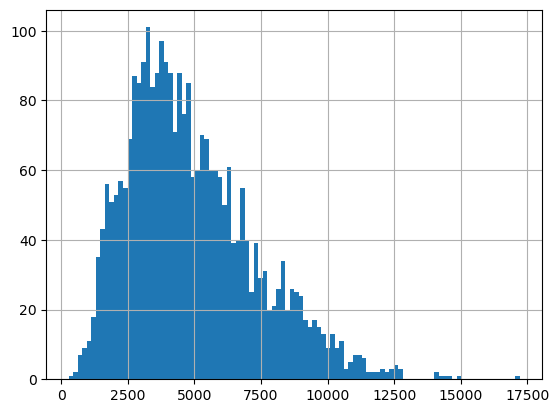

In [9]:
df2 = df.copy()
df2 = df2[df2["fraud"] == 1]
df2["claim_est_payout"].hist(bins=100)

# No, l'aumento della cifra non porta ad un aumento delle frodi, che si concentrano nella fascia 2500-7500

Decision Tree - Accuracy on train set:  1.0
Decision Tree - Accuracy on test set:  0.7490261547022816
Logistic Regression - Accuracy on train set:  0.8426492804325356
Logistic Regression - Accuracy on test set:  0.8454832127620108
Dummy Classifier - Accuracy on train set:  0.8426492804325356
Dummy Classifier - Accuracy on test set:  0.8454832127620108


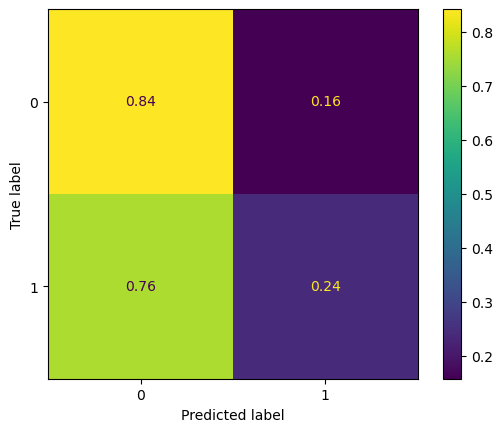

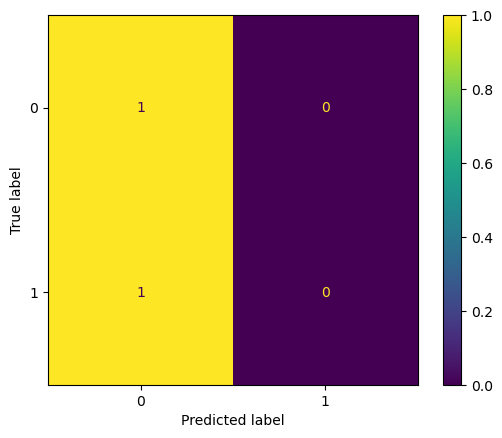

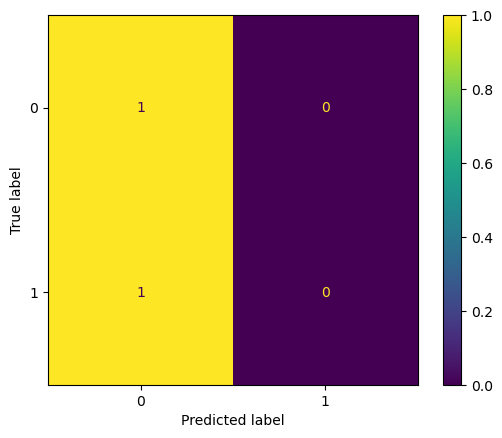

In [10]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

df = pd.read_csv('training_set_fd.csv', sep=';')
df = df.dropna()
df = df.drop(columns=['claim_number'])          # inutile in quanto è un id

# Ordinal encoding
enc = OrdinalEncoder()

categorical = ["vehicle_color", "living_status", "gender", "claim_day_of_week",	"accident_site", "channel", "vehicle_category"]

for i in categorical:
    df[i] = enc.fit_transform(df[[i]])

# Split the dataset
from sklearn.model_selection import train_test_split

X = df.drop(columns=['fraud'])
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_test_pred = dt.predict(X_test)
y_train_pred = dt.predict(X_train)

print("Decision Tree - Accuracy on train set: ", accuracy_score(y_train, y_train_pred))
print("Decision Tree - Accuracy on test set: ", accuracy_score(y_test, y_test_pred))

cm1 = confusion_matrix(y_test, y_test_pred, normalize='true')
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1).plot()

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)

print("Logistic Regression - Accuracy on train set: ", accuracy_score(y_train, y_train_pred))
print("Logistic Regression - Accuracy on test set: ", accuracy_score(y_test, y_test_pred))

cm2 = confusion_matrix(y_test, y_test_pred, normalize='true')
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2).plot()

# Dummy Classifier
dc = DummyClassifier(strategy="most_frequent")
dc.fit(X_train, y_train)

y_test_pred = dc.predict(X_test)
y_train_pred = dc.predict(X_train)

print("Dummy Classifier - Accuracy on train set: ", accuracy_score(y_train, y_train_pred))
print("Dummy Classifier - Accuracy on test set: ", accuracy_score(y_test, y_test_pred))

cm3 = confusion_matrix(y_test, y_test_pred, normalize='true')
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3).plot()

# Il Decision Tree fa overfitting, la Logistic Regression è la migliore ma ha prestazioni comparabili al Dummy Classifier poiché il dataset è fortemente sbilanciato
# L'Accuracy non è una buona metrica per questo dataset, è meglio usare la Precision o la Recall

In [11]:
# Repeat the same task but with a 10 fold cross validation
from sklearn.model_selection import cross_val_score

# Decision Tree
dt = DecisionTreeClassifier()
scores = cross_val_score(dt, X, y, cv=10)
print("Decision Tree - Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Logistic Regression
lr = LogisticRegression()
scores = cross_val_score(lr, X, y, cv=10)
print("Logistic Regression - Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Dummy Classifier
dc = DummyClassifier(strategy="most_frequent")
scores = cross_val_score(dc, X, y, cv=10)
print("Dummy Classifier - Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# L'accuratezza non migliora nemmeno con una 10 fold

Decision Tree - Accuracy: 0.74 (+/- 0.02)
Logistic Regression - Accuracy: 0.84 (+/- 0.00)
Dummy Classifier - Accuracy: 0.84 (+/- 0.00)


In [12]:
# Find the best parameters for logistic regression using grid search
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100], "penalty": ["none", "l2"]}
lr = LogisticRegression()

clf = GridSearchCV(lr, parameters, cv=10)
clf.fit(X, y)

print(clf.best_params_)




/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: Fu

{'C': 0.001, 'penalty': 'none'}


/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [13]:
# Discretize the features claim_est_payout and vehicle_price. Then scale the dataset usign MaxAbsScaler
from sklearn.preprocessing import MaxAbsScaler, KBinsDiscretizer

df2 = df.copy()

# Discretize
est = KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='uniform')
df2["claim_est_payout"] = est.fit_transform(df2[["claim_est_payout"]].values.reshape(-1, 1))
df2["vehicle_price"] = est.fit_transform(df2[["vehicle_price"]].values.reshape(-1, 1))

# Scale
scaler = MaxAbsScaler()
df2 = scaler.fit_transform(df2)
df2 = pd.DataFrame(df2, columns=df.columns)

# Split the dataset
X = df2.drop(columns=['fraud'])
y = df2['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_test_pred = dt.predict(X_test)
y_train_pred = dt.predict(X_train)

print("Decision Tree - Accuracy on train set: ", accuracy_score(y_train, y_train_pred))
print("Decision Tree - Accuracy on test set: ", accuracy_score(y_test, y_test_pred))

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
y_train_pred = lr.predict(X_train)

print("Logistic Regression - Accuracy on train set: ", accuracy_score(y_train, y_train_pred))
print("Logistic Regression - Accuracy on test set: ", accuracy_score(y_test, y_test_pred))

# Dummy Classifier
dc = DummyClassifier(strategy="most_frequent")
dc.fit(X_train, y_train)

y_test_pred = dc.predict(X_test)
y_train_pred = dc.predict(X_train)

print("Dummy Classifier - Accuracy on train set: ", accuracy_score(y_train, y_train_pred))
print("Dummy Classifier - Accuracy on test set: ", accuracy_score(y_test, y_test_pred))

# L'accuratezza sale ma il Dummy classifier rimane la scelta migliore


Decision Tree - Accuracy on train set:  1.0
Decision Tree - Accuracy on test set:  0.7397514375811538
Logistic Regression - Accuracy on train set:  0.8416951578277808
Logistic Regression - Accuracy on test set:  0.8454832127620108
Dummy Classifier - Accuracy on train set:  0.8424902599984098
Dummy Classifier - Accuracy on test set:  0.8458542014468559


In [14]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

discretizer = ColumnTransformer([
    ("payout", KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='uniform'), ["claim_est_payout"]),
    ("price", KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform'), ["vehicle_price"])])

union = FeatureUnion([("discretizer", discretizer), ("passthrough", FunctionTransformer(lambda x: x, validate=False))])

pipeline = Pipeline(steps = [("union", union), ("estimator", LogisticRegression())])

# Fit the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

print("Logistic Regression - Accuracy on train set: ", accuracy_score(y_train, y_train_pred))
print("Logistic Regression - Accuracy on test set: ", accuracy_score(y_test, y_test_pred))

Logistic Regression - Accuracy on train set:  0.8418541782619067
Logistic Regression - Accuracy on test set:  0.8456687071044333


/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
# Add to the pipeline the SelectKBest feature selection method and find the best value for k using grid search
from sklearn.feature_selection import SelectKBest

parameters = {
    'union__discretizer__payout__n_bins': [10, 20, 30, 40, 50],
    'union__discretizer__price__n_bins': [5, 10, 15, 20, 25],
    'selectkbest__k': [1, 5, 10, "all"]
}

extended_pipeline = Pipeline(steps = [("union", union), ("selectkbest", SelectKBest()), ("estimator", LogisticRegression())])

clf = GridSearchCV(extended_pipeline, parameters)
clf.fit(X_train, y_train)

# Evaluate the model
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print("Logistic Regression - Accuracy on train set: ", accuracy_score(y_train, y_train_pred))
print("Logistic Regression - Accuracy on test set: ", accuracy_score(y_test, y_test_pred))

print(clf.best_params_)

/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Logistic Regression - Accuracy on train set:  0.8424902599984098
Logistic Regression - Accuracy on test set:  0.8458542014468559
{'selectkbest__k': 1, 'union__discretizer__payout__n_bins': 10, 'union__discretizer__price__n_bins': 5}


/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lorenzo/miniconda3/envs/BDA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

In [16]:
df3 = df.copy()

# Split the dataset
X = df3.drop(columns=['fraud'], axis=1)
y = df3['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Apply a SimpleImputer to the dataset
from sklearn.impute import SimpleImputer

discretizer = ColumnTransformer([
    ("payout", KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='uniform'), [X_train.columns.get_loc("claim_est_payout")]),
    ("price", KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform'), [X_train.columns.get_loc("vehicle_price")])])

union = FeatureUnion([("discretizer", discretizer), ("passthrough", FunctionTransformer(lambda x: x, validate=False))])

pipeline = Pipeline(steps = [("union", union), ("estimator", LogisticRegression())])
extended_pipeline = Pipeline(steps = [("union", union), ("selectkbest", SelectKBest()), ("estimator", LogisticRegression())])

parameters = {
    'old__union__discretizer__payout__n_bins': [10],
    'old__union__discretizer__price__n_bins': [5],
    'old__selectkbest__k': [1],
    'impute__strategy': ['mean', 'median', 'most_frequent']
}

new_pipeline = Pipeline(steps = [("impute", SimpleImputer()), ("old", extended_pipeline)])

clf = GridSearchCV(new_pipeline, parameters)
clf.fit(X_train, y_train)

# Evaluate the model
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print("Logistic Regression - Accuracy on train set: ", accuracy_score(y_train, y_train_pred))
print("Logistic Regression - Accuracy on test set: ", accuracy_score(y_test, y_test_pred))

clf.best_params_

Logistic Regression - Accuracy on train set:  0.8416951578277808
Logistic Regression - Accuracy on test set:  0.8477091448710814


{'impute__strategy': 'mean',
 'old__selectkbest__k': 1,
 'old__union__discretizer__payout__n_bins': 10,
 'old__union__discretizer__price__n_bins': 5}